In [1]:
import os
import kagglehub

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# Load the heart_rate from dataset
df = pd.read_csv('heartrate_seconds_merged.csv', parse_dates=['Time'])

In [3]:
df.describe()

,Id,Time,Value
count,1.154681e+06,1154681,1.154681e+06
mean,5.352122e+09,2016-04-06 03:14:15.766342656,7.975687e+01
min,2.022484e+09,2016-03-29 00:00:05,3.600000e+01
25%,4.020333e+09,2016-04-03 09:22:40,6.600000e+01
50%,5.553957e+09,2016-04-06 03:55:07,7.700000e+01
75%,6.962181e+09,2016-04-08 19:16:45,9.000000e+01
max,8.877689e+09,2016-04-12 11:03:15,1.850000e+02
std,2.033584e+09,NaN,1.872988e+01


In [4]:
df['Id'].nunique()

14

In [5]:
# Count number of entries for each Id
id_counts = df['Id'].value_counts()
print(id_counts)

Id
4020332650    283794
6962181067    125875
2347167796    120804
5553957443     97797
5577150313     87649
8877689391     85115
8792009665     70087
4558609924     69339
7007744171     64786
2022484408     56483
6117666160     53666
6775888955     35100
6391747486      3747
2026352035       439
Name: count, dtype: int64


# For Id=4020332650

In [6]:
# Select only 'Time' and 'Value' columns for Id = 4020332650
#first_id = df['Id'].iloc[0]
df_max_id = df[df['Id'] == 4020332650][['Time', 'Value']]
df_max_id.head()

,Time,Value
177726,2016-04-01 01:03:18,71
177727,2016-04-01 01:03:21,71
177728,2016-04-01 01:03:24,71
177729,2016-04-01 01:03:27,71
177730,2016-04-01 01:03:30,71


In [7]:
df = df_max_id.set_index('Time')
df.index = pd.to_datetime(df.index)
df = df.sort_index()

In [8]:
df.describe()

,Value
count,283794.000000
mean,81.901798
std,14.632968
min,46.000000
25%,70.000000
50%,84.000000
75%,93.000000
max,151.000000


In [9]:
# Resample to 1-minute intervals, taking the mean value for each minute
df_min = df.resample('1T').mean(numeric_only=True)

# Check the result
df_min.head()

C:\Users\ronys\AppData\Local\Temp\ipykernel_2260\856579433.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_min = df.resample('1T').mean(numeric_only=True)


,Value
Time,
2016-04-01 01:03:00,68.684211
2016-04-01 01:04:00,64.518519
2016-04-01 01:05:00,68.423077
2016-04-01 01:06:00,67.655172
2016-04-01 01:07:00,67.240000


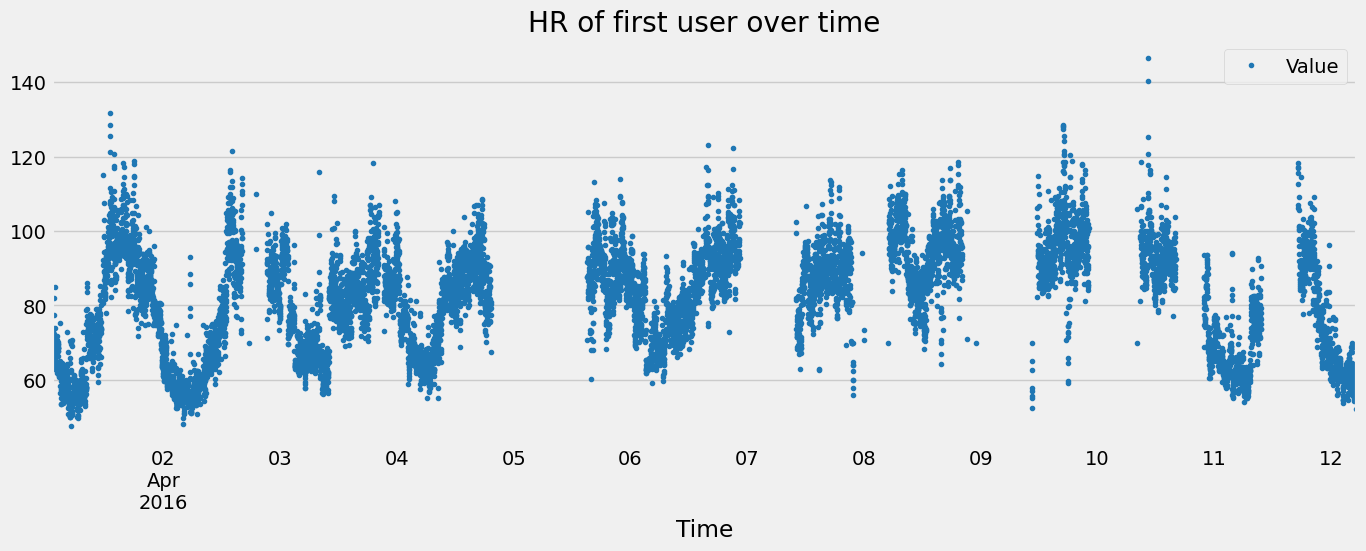

In [10]:
df_min.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='HR of first user over time')
plt.show()

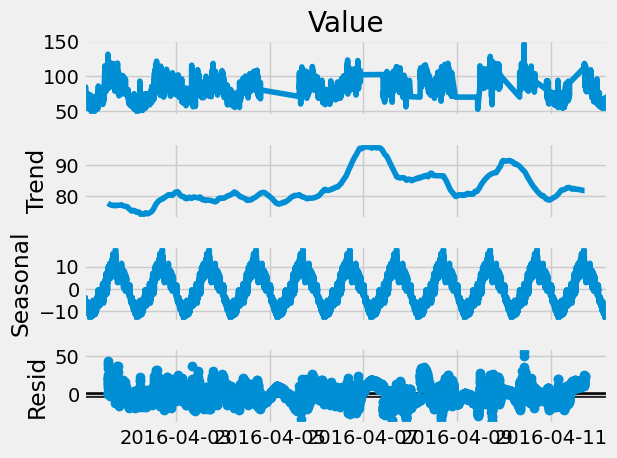

In [11]:
# Fill missing values by interpolation
df_min_filled = df_min['Value'].interpolate()

# Or, to simply drop missing values (may affect regularity)
# df_min_filled = df_min['Value'].dropna()

result = seasonal_decompose(df_min_filled, model='additive', period=60*24)
result.plot()
plt.show()

# Filling missing values with the average value for that minute across all days.

In [12]:
# Make sure 'Time' is the index and is datetime type
df_sorted = df_max_id.set_index('Time')
df_sorted.index = pd.to_datetime(df_sorted.index)

# Resample to 1-minute intervals (creates missing minutes as NaN)
df_min = df_sorted.resample('1T').mean(numeric_only=True)

# Extract minute of day for each timestamp
df_min['minute_of_day'] = df_min.index.hour * 60 + df_min.index.minute

# Compute average value for each minute of the day (across all days)
minute_avg = df_min.groupby('minute_of_day')['Value'].mean()

# Fill missing values with the average for that minute of the day
df_min['Value'] = df_min.apply(
    lambda row: minute_avg[row['minute_of_day']] if pd.isna(row['Value']) else row['Value'],
    axis=1
)

# Now df_min['Value'] has no missing values, and each missing minute is filled with its typical value

C:\Users\ronys\AppData\Local\Temp\ipykernel_2260\1242785015.py:6: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_min = df_sorted.resample('1T').mean(numeric_only=True)


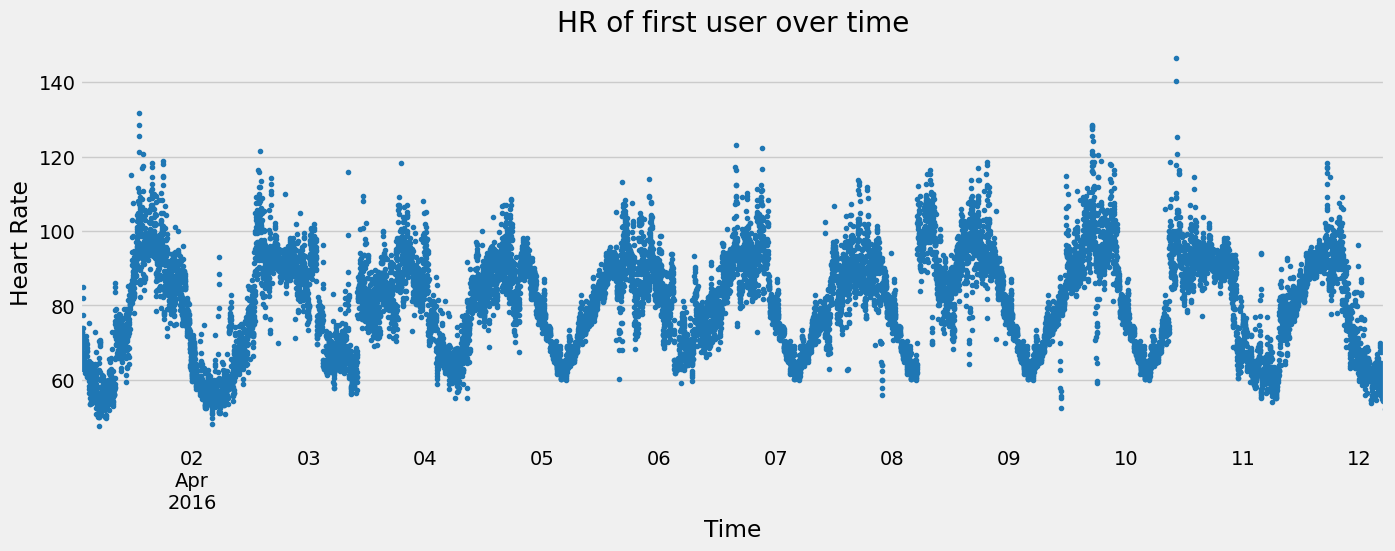

In [13]:
df_min['Value'].plot(
    style='.',
    figsize=(15, 5),
    color=color_pal[0],
    title='HR of first user over time'
)
plt.xlabel('Time')
plt.ylabel('Heart Rate')
plt.show()

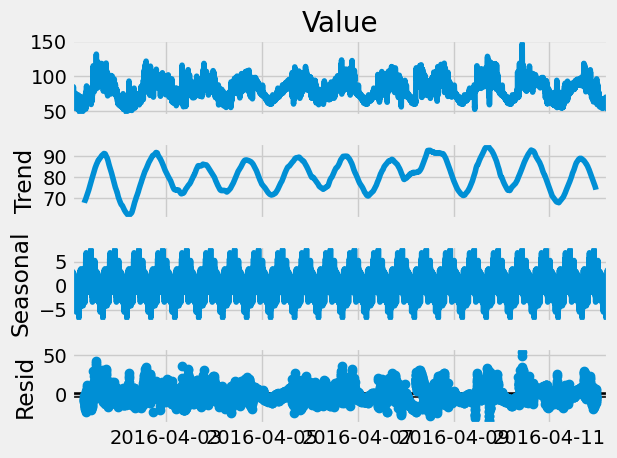

In [14]:
# Fill missing values by interpolation
df_min_filled = df_min['Value'].interpolate()

# Or, to simply drop missing values (may affect regularity)
# df_min_filled = df_min['Value'].dropna()

result = seasonal_decompose(df_min_filled, model='additive', period=60*12)
result.plot()
plt.show()

In [15]:
df_min_filled.head()

Time
2016-04-01 01:03:00    68.684211
2016-04-01 01:04:00    64.518519
2016-04-01 01:05:00    68.423077
2016-04-01 01:06:00    67.655172
2016-04-01 01:07:00    67.240000
Freq: min, Name: Value, dtype: float64

* # Train Test data 

<Figure size 640x480 with 0 Axes>

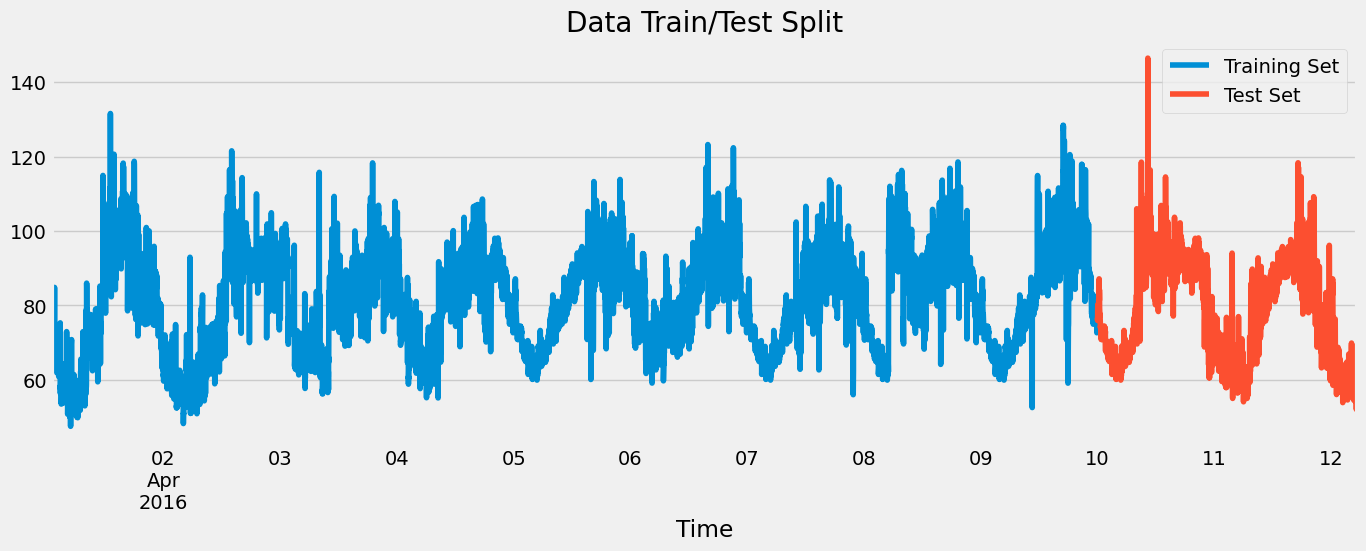

In [16]:
df=df_min_filled.to_frame()
train = df.loc[df.index < '2016-04-10']
test = df.loc[df.index >= '2016-04-10']
plt.clf()
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('10-04-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

## **Feature Engineering**

In [17]:
def create_features(df):
    """
    Create time series features and lag features based on time series index.
    """
    df = df.copy()

    # Basic time-based features
    df['minute'] = df.index.minute
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month

    # Lag features
    df['lag_1minute'] = df['Value'].shift(1)  # 1 minute lag
    df['lag_1h'] = df['Value'].shift(60)   # 1 hour lag
    df['lag_1d'] = df['Value'].shift(1440)  # 1 day lag
    df['lag_1w'] = df['Value'].shift(10080) # 1 week lag

    # Rolling statistics features
    df['rolling_mean_30minutes'] = df['Value'].rolling(window=30).mean()  # Last 30 minutes rolling mean
    df['rolling_mean_3hours'] = df['Value'].rolling(window=180).mean()  # Last 3 hours rolling mean
    df['rolling_mean_3days'] = df['Value'].rolling(window=4320).mean()  # Last 3 days rolling mean
    df['rolling_mean_same_hour_last_day'] = df['Value'].shift(1440).rolling(window=30).mean()  # Same hour previous day rolling mean
    df['rolling_mean_same_hour_last_week'] = df['Value'].shift(10080).rolling(window=7).mean()  # Same hour previous week rolling mean

    return df

df = create_features(df_min_filled.to_frame())

In [18]:
df.head

<bound method NDFrame.head of                          Value  minute  hour  day  dayofweek  month  \
Time                                                                  
2016-04-01 01:03:00  68.684211       3     1    1          4      4   
2016-04-01 01:04:00  64.518519       4     1    1          4      4   
2016-04-01 01:05:00  68.423077       5     1    1          4      4   
2016-04-01 01:06:00  67.655172       6     1    1          4      4   
2016-04-01 01:07:00  67.240000       7     1    1          4      4   
...                        ...     ...   ...  ...        ...    ...   
2016-04-12 05:15:00  63.000000      15     5   12          1      4   
2016-04-12 05:16:00  63.000000      16     5   12          1      4   
2016-04-12 05:17:00  63.000000      17     5   12          1      4   
2016-04-12 05:18:00  63.000000      18     5   12          1      4   
2016-04-12 05:19:00  63.000000      19     5   12          1      4   

                     lag_1minute     lag_1h   

## **Visualization Feature/Target Relationship**

<Figure size 640x480 with 0 Axes>

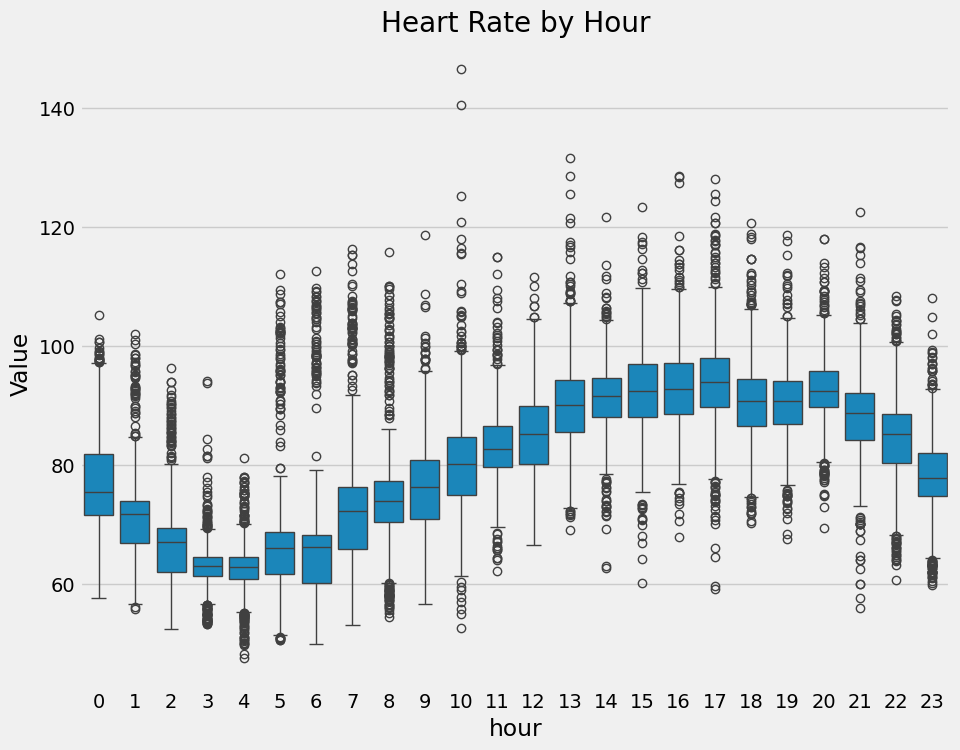

In [19]:
plt.clf()
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='Value', ax=ax)
ax.set_title('Heart Rate by Hour')
plt.show()

C:\Users\ronys\AppData\Local\Temp\ipykernel_2260\2187822440.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='dayofweek', y='Value', palette='Blues')


<Figure size 640x480 with 0 Axes>

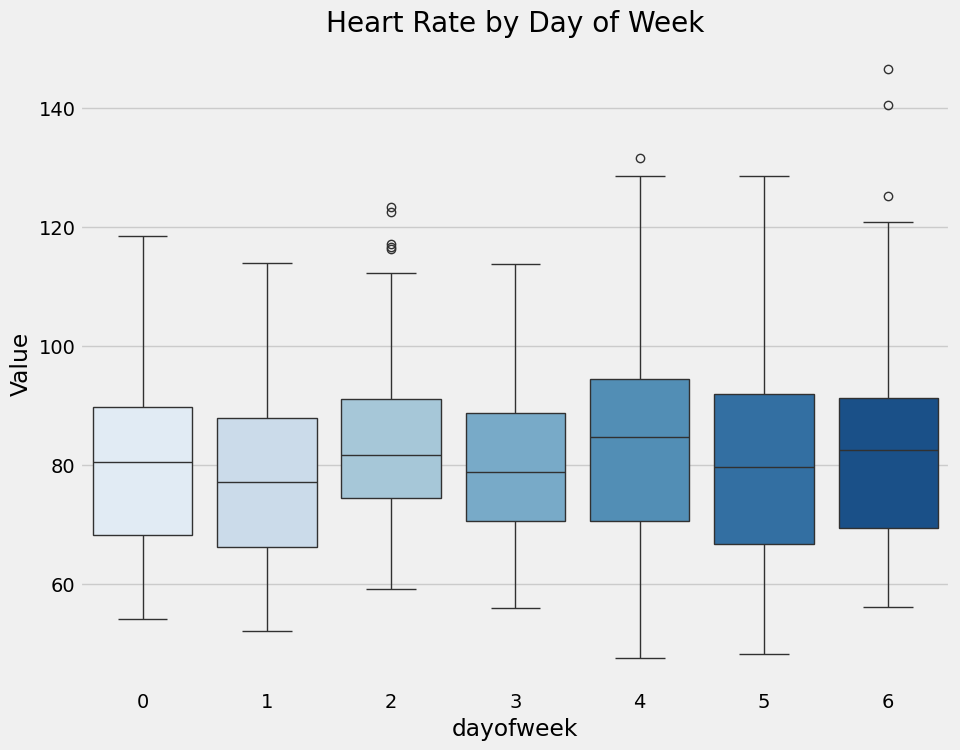

In [20]:
plt.clf()
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='dayofweek', y='Value', palette='Blues')
ax.set_title('Heart Rate by Day of Week')
plt.show()

## **Preparing Data For Modelling**

In [21]:
train = create_features(train)
test = create_features(test)


TARGET = 'Value'


FEATURES_XGB = [
    'hour', 'dayofweek', 'month', 'minute', 'day','lag_1minute', 'lag_1h', 'lag_1d', 'lag_1w',
    'rolling_mean_30minutes', 'rolling_mean_3hours', 'rolling_mean_3days', 'rolling_mean_same_hour_last_day', 'rolling_mean_same_hour_last_week'
]

In [22]:
# XGBoost Data
X_train_xgb = train[FEATURES_XGB]
y_train_xgb = train[TARGET]

X_test_xgb = test[FEATURES_XGB]
y_test_xgb = test[TARGET]

# **XGBoost**

In [23]:
# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train_xgb, label=y_train_xgb)
dtest = xgb.DMatrix(X_test_xgb, label=y_test_xgb)

# Set parameters for XGBoost
params = {
    'objective': 'reg:squarederror',  # Objective function for regression
    'eval_metric': 'rmse',  # Evaluation metric
    'max_depth': 3,  # Depth of the trees
    'learning_rate': 0.01,  # Learning rate
    'colsample_bytree': 0.8,  # Subsample of features
    'subsample': 0.8  # Subsample ratio
}

# Watchlist for monitoring performance on train and test sets
watchlist = [(dtrain, 'train'), (dtest, 'eval')]

# Number of boosting rounds and early stopping
num_round = 1000  # Number of boosting rounds
early_stopping_rounds = 50  # Early stopping

# Train the model
reg = xgb.train(params, dtrain, num_round, watchlist, early_stopping_rounds=early_stopping_rounds,verbose_eval=100)

# # Predict on the test set
y_pred_xgb = reg.predict(dtest)

# # Evaluate the performance (optional, to see RMSE)
# from sklearn.metrics import mean_squared_error
# rmse = mean_squared_error(y_test, y_pred, squared=False)
# print(f"Test RMSE: {rmse}")

[0]	train-rmse:13.04414	eval-rmse:13.65565
[100]	train-rmse:6.15378	eval-rmse:6.11316


c:\Users\ronys\Documents\RUC\advanced-project\A_P_Python\advanced-project\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[200]	train-rmse:4.21368	eval-rmse:3.92546
[300]	train-rmse:3.79684	eval-rmse:3.45910
[400]	train-rmse:3.70701	eval-rmse:3.37774
[500]	train-rmse:3.67140	eval-rmse:3.35493
[600]	train-rmse:3.64878	eval-rmse:3.34751
[700]	train-rmse:3.63199	eval-rmse:3.34470
[800]	train-rmse:3.61722	eval-rmse:3.34166
[900]	train-rmse:3.60346	eval-rmse:3.33952
[999]	train-rmse:3.59065	eval-rmse:3.33868


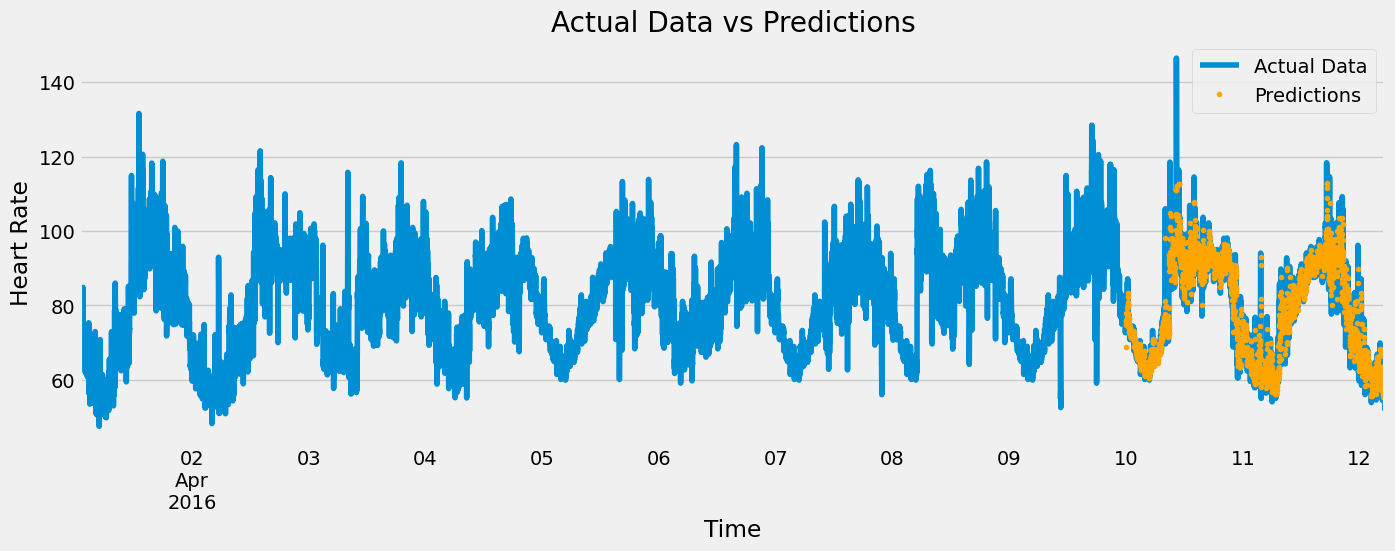

In [24]:
# Ensure that 'prediction' column is added only once
if 'prediction' not in df.columns:
    test['prediction'] = reg.predict(dtest)
    df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

# Plot the actual and predicted values
ax = df[['Value']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.', color='orange')

# Add labels and legend
plt.legend(['Actual Data', 'Predictions'])
ax.set_title('Actual Data vs Predictions')
plt.xlabel('Time')
plt.ylabel('Heart Rate')

# Show the plot
plt.show()

In [25]:
# @title **Evaluating XGBoost**
rmse_xgb = np.sqrt(mean_squared_error(y_test_xgb, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test_xgb, y_pred_xgb)

print(f"XGBoost - RMSE: {rmse_xgb}")
print(f"XGBoost - MAE: {mae_xgb}")

XGBoost - RMSE: 3.3386753418792616
XGBoost - MAE: 2.0749338420398096


# Making predictoin

In [26]:
# 1. Define the target time
target_time = pd.to_datetime('2016-04-13 01:03:00')

# 2. Create a new row with the correct index
row = pd.DataFrame(index=[target_time])

# 3. Concatenate this row to your df to ensure all lags/rolling can be calculated
df_with_row = pd.concat([df, row])
df_with_row = df_with_row.sort_index()

# 4. Create features for the new row (this will use previous data for lags/rolling)
df_with_row = create_features(df_with_row)

# 5. Select the last row (the one for prediction)
X_row = df_with_row.loc[[target_time], FEATURES_XGB]

# 6. Predict using the trained model
drow = xgb.DMatrix(X_row)
predicted_hr = reg.predict(drow)[0]

print(f"Predicted HR at {target_time}: {predicted_hr:.2f}")

Predicted HR at 2016-04-13 01:03:00: 64.27


# CNN


In [27]:
from tensorflow import keras
from tensorflow.keras import layers

# 1. Prepare data
X_train = train[FEATURES_XGB].values
y_train = train[TARGET].values
X_test = test[FEATURES_XGB].values
y_test = test[TARGET].values

# 2. Build the model
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)  # Output layer for regression
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 3. Train the model
model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2)

# 4. Predict
y_pred_nn = model.predict(X_test).flatten()

# 5. Evaluate
from sklearn.metrics import mean_squared_error, mean_absolute_error
rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred_nn))
mae_nn = mean_absolute_error(y_test, y_pred_nn)
print(f"Neural Network - RMSE: {rmse_nn}")
print(f"Neural Network - MAE: {mae_nn}")

Epoch 1/20


c:\Users\ronys\Documents\RUC\advanced-project\A_P_Python\advanced-project\venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6422.5908 - mae: 79.1166 - val_loss: 7600.6846 - val_mae: 86.2058
Epoch 2/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6253.9399 - mae: 78.0424 - val_loss: 7334.7900 - val_mae: 84.6495
Epoch 3/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5942.7207 - mae: 76.0240 - val_loss: 6920.5854 - val_mae: 82.1665
Epoch 4/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5510.5615 - mae: 73.1209 - val_loss: 6387.8110 - val_mae: 78.8579
Epoch 5/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4987.8765 - mae: 69.4532 - val_loss: 5770.0703 - val_mae: 74.8387
Epoch 6/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4406.5498 - mae: 65.1277 - val_loss: 5100.7007 - val_mae: 70.2243
Epoch 7/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3797.6001 - mae: 60.2672 - val_loss: 4411.8901 - val_mae: 65.1356
Epoch 8/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3190.0242 - mae: 54.9940 - val_loss: 3732.8733 - val_mae: 59.6961
Epo

# LSTM

In [28]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

FEATURES_XGB = [
    'hour', 'dayofweek', 'month', 'minute', 'day'
]

# 1. Prepare data for LSTM
window_size = 60  # Use last 60 minutes
features = FEATURES_XGB  # Use your feature list

def create_lstm_dataset(df, features, window_size):
    X, y = [], []
    values = df[features].values
    targets = df[TARGET].values
    for i in range(window_size, len(df)):
        X.append(values[i-window_size:i])
        y.append(targets[i])
    return np.array(X), np.array(y)

# Create LSTM datasets for train and test
X_train_lstm, y_train_lstm = create_lstm_dataset(train, features, window_size)
X_test_lstm, y_test_lstm = create_lstm_dataset(test, features, window_size)

# 2. Build the LSTM model
model = keras.Sequential([
    keras.layers.LSTM(units=128, input_shape=(window_size, len(features)), return_sequences=True),
    keras.layers.LSTM(units=64),  # Second LSTM layer
    keras.layers.Dense(units=1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 3. Train the model
model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=64, validation_split=0.2)

# 4. Predict
y_pred_lstm = model.predict(X_test_lstm).flatten()

# 5. Evaluate
from sklearn.metrics import mean_squared_error, mean_absolute_error
rmse_lstm = np.sqrt(mean_squared_error(y_test_lstm, y_pred_lstm))
mae_lstm = mean_absolute_error(y_test_lstm, y_pred_lstm)
print(f"LSTM - RMSE: {rmse_lstm}")
print(f"LSTM - MAE: {mae_lstm}")

Epoch 1/10


c:\Users\ronys\Documents\RUC\advanced-project\A_P_Python\advanced-project\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


161/161 ━━━━━━━━━━━━━━━━━━━━ 15s 70ms/step - loss: 4403.5742 - mae: 64.9508 - val_loss: 4533.8491 - val_mae: 66.0688
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - loss: 3064.0659 - mae: 53.7849 - val_loss: 3332.0916 - val_mae: 56.2435
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - loss: 2144.2654 - mae: 44.4289 - val_loss: 2422.6519 - val_mae: 47.4751
Epoch 4/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - loss: 1478.1569 - mae: 36.1934 - val_loss: 1748.4254 - val_mae: 39.7450
Epoch 5/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - loss: 1004.7944 - mae: 28.9520 - val_loss: 1256.8483 - val_mae: 32.9871
Epoch 6/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - loss: 679.1190 - mae: 22.8194 - val_loss: 906.5989 - val_mae: 27.1794
Epoch 7/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - loss: 464.0969 - mae: 18.1152 - val_loss: 664.2482 - val_mae: 22.4805
Epoch 8/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 13s 81ms/step - loss: 329.2408 - mae: 14.9521 - val_loss: 501.5637 - val_mae: 1

In [29]:
# Check if all timestamps are present
expected_index = pd.date_range(start=target_time - pd.Timedelta(minutes=window_size), 
                              end=target_time - pd.Timedelta(minutes=1), freq='T')
missing = set(expected_index) - set(df.index)
print("Missing timestamps:", missing)

Missing timestamps: {Timestamp('2016-04-13 00:58:00'), Timestamp('2016-04-13 01:02:00'), Timestamp('2016-04-13 00:13:00'), Timestamp('2016-04-13 00:48:00'), Timestamp('2016-04-13 00:10:00'), Timestamp('2016-04-13 00:24:00'), Timestamp('2016-04-13 00:40:00'), Timestamp('2016-04-13 00:39:00'), Timestamp('2016-04-13 00:51:00'), Timestamp('2016-04-13 00:04:00'), Timestamp('2016-04-13 00:06:00'), Timestamp('2016-04-13 00:07:00'), Timestamp('2016-04-13 00:09:00'), Timestamp('2016-04-13 00:26:00'), Timestamp('2016-04-13 00:17:00'), Timestamp('2016-04-13 01:01:00'), Timestamp('2016-04-13 00:27:00'), Timestamp('2016-04-13 00:22:00'), Timestamp('2016-04-13 00:52:00'), Timestamp('2016-04-13 00:19:00'), Timestamp('2016-04-13 00:35:00'), Timestamp('2016-04-13 00:14:00'), Timestamp('2016-04-13 00:12:00'), Timestamp('2016-04-13 00:05:00'), Timestamp('2016-04-13 00:45:00'), Timestamp('2016-04-13 00:32:00'), Timestamp('2016-04-13 00:57:00'), Timestamp('2016-04-13 00:50:00'), Timestamp('2016-04-13 00:43

C:\Users\ronys\AppData\Local\Temp\ipykernel_2260\154520798.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  expected_index = pd.date_range(start=target_time - pd.Timedelta(minutes=window_size),


In [30]:
input_seq = df.loc[input_start:input_end, FEATURES_XGB]
print(input_seq.isnull().sum())

NameError: name 'input_start' is not defined

In [ ]:
# Ensure regular time index
df = df.asfreq('T')  # Fills in missing minutes with NaN
df[FEATURES_XGB] = df[FEATURES_XGB].interpolate()  # Interpolate missing feature values

In [ ]:
import pandas as pd
import numpy as np

# 1. Set the target time and window size
target_time = pd.to_datetime('2016-04-13 01:03:00')
window_size = 60  # Should match your LSTM training

# 2. Get the previous window_size rows ending just before the target time
input_end = target_time - pd.Timedelta(minutes=1)
input_start = input_end - pd.Timedelta(minutes=window_size-1)
input_seq = df.loc[input_start:input_end, FEATURES_XGB].values

# 3. Check shape and reshape for LSTM input
if input_seq.shape[0] == window_size:
    input_seq = input_seq.reshape(1, window_size, len(FEATURES_XGB))
    # 4. Predict
    predicted_hr = model.predict(input_seq)[0, 0]
    print(f"LSTM predicted HR at {target_time}: {predicted_hr:.2f}")
else:
    print("Not enough data to create input sequence for prediction.")